In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage.io import imread
from vd_functions import *
from sklearn.model_selection import train_test_split

In [2]:
# Read in cars and notcars
car_images = glob.glob('vehicles/*/*.png')
noncar_images = glob.glob('non-vehicles/*/*.png')

cars = []
for image in car_images:
    cars.append(image)
    
notcars = []
for image in noncar_images:
    notcars.append(image)
    
print("Number of car images:", len(cars), "  Number of non-car images:", len(notcars))

Number of car images: 8792   Number of non-car images: 8968


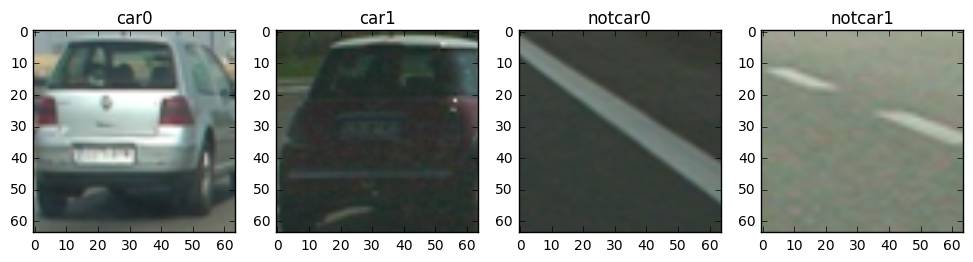

In [3]:
# Function for plotting multiple images
%matplotlib inline
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            
images = [imread(cars[0]), imread(cars[1]), imread(notcars[0]), imread(notcars[1])]
#images = [imread(cars[2]), imread(cars[3]), imread(notcars[2]), imread(notcars[3])]

titles = ['car0', 'car1', 'notcar0', 'notcar1']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

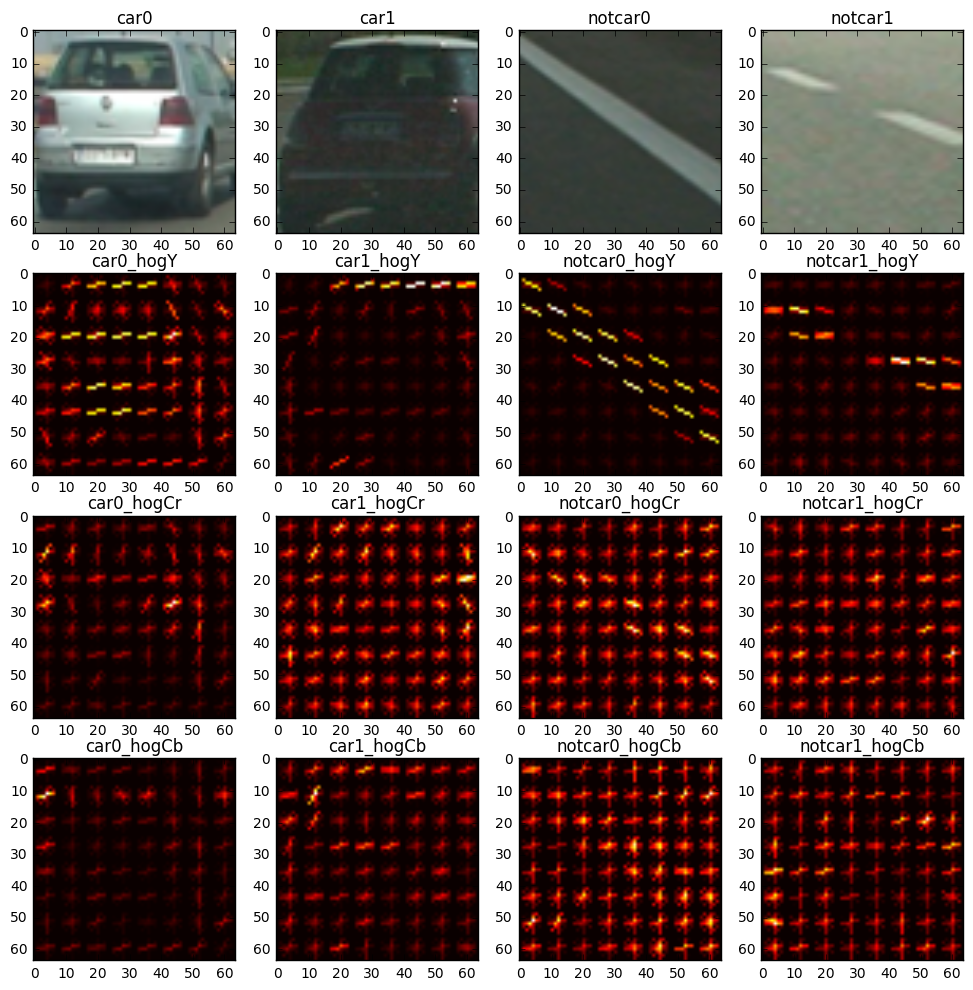

In [4]:
# Visualize HOG for various channels

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

hogY_images = []
hogCr_images = []
hogCb_images = []

for image in images:
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)    
    features, hogY_image = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, 
                                           cell_per_block, vis = True, feature_vec = False)
    features, hogCr_image = get_hog_features(feature_image[:,:,1], orient, pix_per_cell, 
                                           cell_per_block, vis = True, feature_vec = False)
    features, hogCb_image = get_hog_features(feature_image[:,:,2], orient, pix_per_cell, 
                                           cell_per_block, vis = True, feature_vec = False)
    hogY_images.append(hogY_image)
    hogCr_images.append(hogCr_image)
    hogCb_images.append(hogCb_image)
    
    
hogY_titles = ['car0_hogY', 'car1_hogY', 'notcar0_hogY', 'notcar1_hogY']
hogCr_titles = ['car0_hogCr', 'car1_hogCr', 'notcar0_hogCr', 'notcar1_hogCr']
hogCb_titles = ['car0_hogCb', 'car1_hogCb', 'notcar0_hogCb', 'notcar1_hogCb']

fig = plt.figure(figsize=(12,12))
visualize(fig, 4, 4, images+hogY_images+hogCr_images+hogCb_images, titles+hogY_titles+hogCr_titles+hogCb_titles)

In [5]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
#y_start_stop = [360, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
11.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


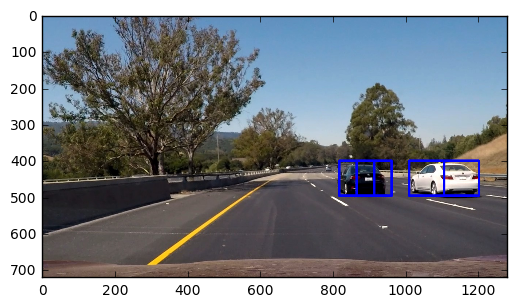

In [6]:
image = imread('test_images/test6.jpg')
image = image.astype(np.float32)/255
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96,96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=6)   
#window_img = draw_boxes(draw_image, windows, color=(0, 0, 1), thick=6)   


plt.imshow(window_img)

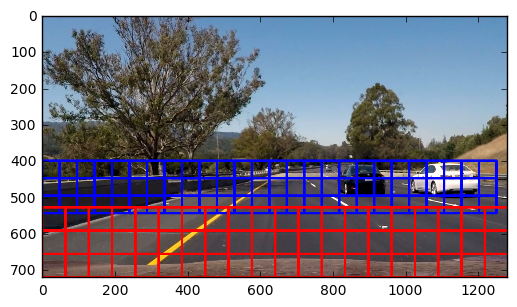

In [15]:
y_start_stop_1 = [400, 544]
windows_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_1, 
                    xy_window=(96,96), xy_overlap=(0.5, 0.5))
y_start_stop_2 = [528, 720]
windows_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_2, 
                    xy_window=(128,128), xy_overlap=(0.5, 0.5))

window_img_1 = draw_boxes(draw_image, windows_1, color=(0, 0, 1), thick=6)  
window_img_2 = draw_boxes(window_img_1, windows_2, color=(1, 0, 0), thick=6)  

plt.imshow(window_img_2)

In [28]:
def draw_hot_windows(image):
    image = image.astype(np.float32)/255
    draw_image = np.copy(image)
    
    y_start_stop_1 = [400, 544]
    #y_start_stop_1 = [384, 528]
    windows_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_1, 
                        xy_window=(96,96), xy_overlap=(0.5, 0.5))
    
    #y_start_stop_2 = [464, 656]
    y_start_stop_2 = [528, 720]
    windows_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_2, 
                        xy_window=(128,128), xy_overlap=(0.5, 0.5))
    
    hot_windows_1 = search_windows(image, windows_1, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

    hot_windows_2 = search_windows(image, windows_2, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
        
    hot_window_img_1 = draw_boxes(draw_image, hot_windows_1, color=(0, 0, 1), thick=6)   
    hot_window_img = draw_boxes(hot_window_img_1, hot_windows_2, color=(1, 0, 0), thick=6)

    return hot_window_img
    

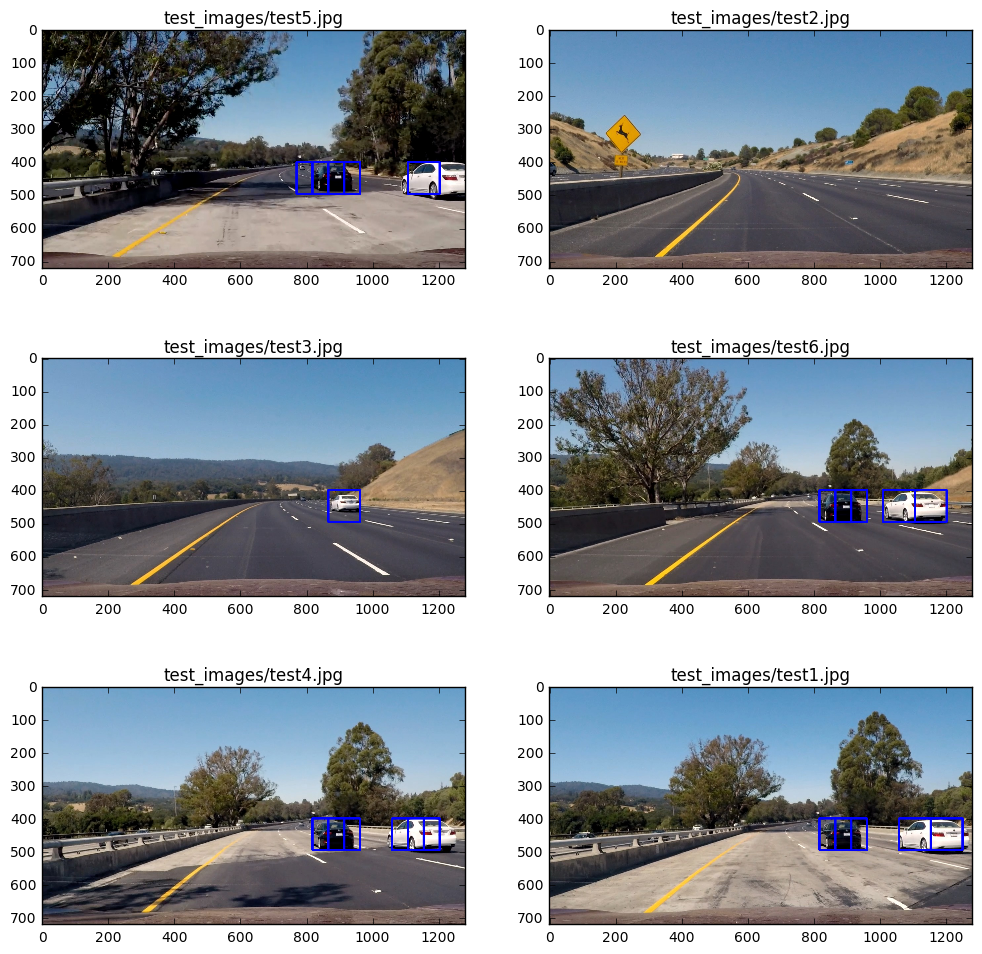

In [29]:
test_images = glob.glob('test_images/*.jpg')
drawn_test_images = []
drawn_test_titles = []
for test_image in test_images:
    image = imread(test_image)
    drawn_test_images.append(draw_hot_windows(image))
    drawn_test_titles.append(test_image)
  
fig = plt.figure(figsize=(12,12))
visualize(fig, 3, 2, drawn_test_images, drawn_test_titles)

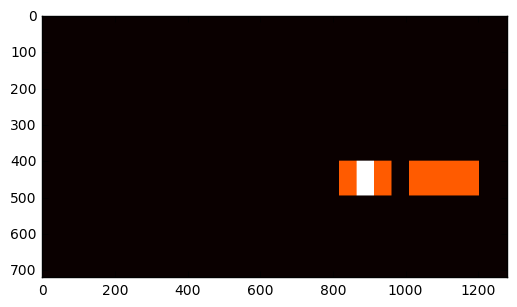

In [30]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

image = imread('test_images/test6.jpg')
image = image.astype(np.float32)/255

hot_windows_1 = search_windows(image, windows_1, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

hot_windows_2 = search_windows(image, windows_2, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 


heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat, hot_windows_1)
heat = add_heat(heat, hot_windows_2)

plt.imshow(heat, cmap='hot')

In [78]:
class VehicleHeatMap():
    '''Class to accumulate heatmap of detected vehicles over multiple frames

    Attributes:
        fit: 
    '''
    def __init__(self):
        self.fit = None
        self.curv = None
        self.x = None
        self.frame_count = 0

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img 

def get_heat(image):
    
    y_start_stop_1 = [400, 544]
    windows_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_1, 
                        xy_window=(96,96), xy_overlap=(0.5, 0.5))
    
    y_start_stop_2 = [528, 720]
    windows_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_2, 
                        xy_window=(128,128), xy_overlap=(0.5, 0.5))
    
    hot_windows_1 = search_windows(image, windows_1, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

    hot_windows_2 = search_windows(image, windows_2, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows_1)
    heat = add_heat(heat, hot_windows_2)
    
    return heat
     
def get_heat_sum(heat):
    global recent_heat_array
    
    recent_heat_array.append(heat)
    if len(recent_heat_array) > 15:
        recent_heat_array.pop(0)
        
    sum_h = np.zeros_like(heat).astype(np.float)
    for h in recent_heat_array:
        sum_h += h
    
    return sum_h
    
def process_image(image):
    '''Main image pipeline
    Args:
        image: Input image, or a frame from incoming video
    Returns:
        result: Output image, after vehicle detection bbox drawn back
    '''
    image = image.astype(np.float32)/255
    heat = get_heat(image)
    heat_sum = get_heat_sum(heat)
    heat_sum[heat_sum <= 5] = 0
    #labels = label(heat)
    labels = label(heat_sum)
    draw_img = draw_labeled_bboxes(255*np.copy(image), labels)
        
    return draw_img
    

In [79]:
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
recent_heat_array = []
project_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(process_image)
project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<07:27,  2.81it/s]

  0%|          | 2/1261 [00:00<07:28,  2.81it/s]

  0%|          | 3/1261 [00:01<07:29,  2.80it/s]

  0%|          | 4/1261 [00:01<07:29,  2.80it/s]

  0%|          | 5/1261 [00:01<07:29,  2.79it/s]

  0%|          | 6/1261 [00:02<07:29,  2.79it/s]

  1%|          | 7/1261 [00:02<07:29,  2.79it/s]

  1%|          | 8/1261 [00:02<07:05,  2.95it/s]

  1%|          | 9/1261 [00:03<06:48,  3.07it/s]

  1%|          | 10/1261 [00:03<06:36,  3.15it/s]

  1%|          | 11/1261 [00:03<06:28,  3.22it/s]

  1%|          | 12/1261 [00:03<06:23,  3.26it/s]

  1%|          | 13/1261 [00:04<06:20,  3.28it/s]

  1%|          | 14/1261 [00:04<06:19,  3.29it/s]

  1%|          | 15/1261 [00:04<06:18,  3.30it/s]

  1%|▏         | 16/1261 [00:05<06:16,  3.30it/s]

  1%|▏         | 17/1261 [00:05<06:15,  3.31it/s]

  1%|▏         | 18/1261 [00:05<06:14,  3.32it/s]

  2%|▏         | 19/1261 [00:06<06:13,  3.32it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

